In [110]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sportsreference.ncaab.teams import Teams
from sportsreference.ncaab.teams import Team
from sportsreference.ncaab.roster import Player
from tqdm import tqdm
from sportsreference.ncaab.boxscore import Boxscore
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler

In [149]:
df = pd.read_csv("ml_df_l3.csv")
df = df.drop(columns = [df.columns[i] for i in [0,71,72,74,75,78,79,7,8,17,42,43,62,73]],axis = 1)
df.isna().sum()

assist_percentage                       0
block_percentage                        0
effective_field_goal_percentage         0
field_goal_percentage                   0
free_throw_attempt_rate                 0
                                       ..
opp_total_rebound_percentage_allowed    0
opp_true_shooting_percentage_allowed    0
opp_turnover_percentage_allowed         0
home                                    0
result                                  0
Length: 66, dtype: int64

## Ensuring All Features Are Scaled Appropriately

In [34]:
scale_dict = {}
for i in df.loc[:,df.columns[df.columns.str.contains('percent')]].columns:
    if df[i].max() > 1:
        scale_dict[i] = MinMaxScaler(feature_range=(0,1))
for key,val in scale_dict.items():
    df[key] = scale_dict[key].fit_transform(df[key].values.reshape(-1,1))

X = df.drop('result',1)
y = df.result
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)
X_train.sample(5)

,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,offensive_rating,offensive_rebound_percentage,allowed_assist_percentage,allowed_block_percentage,allowed_effective_field_goal_percentage,allowed_field_goal_percentage,allowed_free_throw_attempt_rate,allowed_free_throw_percentage,allowed_offensive_rebound_percentage,allowed_steal_percentage,allowed_three_point_attempt_rate,allowed_three_point_field_goal_percentage,allowed_two_point_field_goal_percentage,allowed_total_rebound_percentage,allowed_true_shooting_percentage,allowed_turnover_percentage,pace,simple_rating_system,steal_percentage,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage,opp_assist_percentage,opp_block_percentage,opp_effective_field_goal_percentage,opp_field_goal_percentage,opp_free_throw_attempt_rate,opp_free_throw_percentage,opp_offensive_rating,opp_offensive_rebound_percentage,opp_pace,opp_simple_rating_system,opp_steal_percentage,opp_three_point_attempt_rate,opp_three_point_field_goal_percentage,opp_two_point_field_goal_percentage,opp_total_rebound_percentage,opp_true_shooting_percentage,opp_turnover_percentage,opp_win_percentage,opp_assist_percentage_allowed,opp_block_percentage_allowed,opp_effective_field_goal_percentage_allowed,opp_field_goal_percentage_allowed,opp_free_throw_attempt_rate_allowed,opp_free_throw_percentage_allowed,opp_offensive_rebound_percentage_allowed,opp_steal_percentage_allowed,opp_three_point_attempt_rate_allowed,opp_three_point_field_goal_percentage_allowed,opp_two_point_field_goal_percentage_allowed,opp_total_rebound_percentage_allowed,opp_true_shooting_percentage_allowed,opp_turnover_percentage_allowed,home,result
0,0.622951,0.520468,0.513,0.447,0.398,0.742,108.9,0.605735,0.559902,0.701754,0.486,0.426,0.398,0.732,0.594470,0.445652,0.354,0.343,0.471,0.381188,0.532,0.437126,64.5,11.75,0.649123,0.377,0.352,0.505,0.618812,0.556,0.382812,0.658,0.256831,0.643275,0.517,0.466,0.456,0.722,106.6,0.727599,66.1,12.63,0.412281,0.268,0.380,0.497,0.633663,0.560,0.609375,0.611,0.388753,0.438596,0.454,0.399,0.362,0.691,0.811060,0.543478,0.336,0.329,0.435,0.366337,0.494,0.407186,0,1
1,0.256831,0.643275,0.517,0.466,0.456,0.722,106.6,0.727599,0.388753,0.438596,0.454,0.399,0.362,0.691,0.811060,0.543478,0.336,0.329,0.435,0.366337,0.494,0.407186,66.1,12.63,0.412281,0.268,0.380,0.497,0.633663,0.560,0.609375,0.611,0.622951,0.520468,0.513,0.447,0.398,0.742,108.9,0.605735,64.5,11.75,0.649123,0.377,0.352,0.505,0.618812,0.556,0.382812,0.658,0.559902,0.701754,0.486,0.426,0.398,0.732,0.594470,0.445652,0.354,0.343,0.471,0.381188,0.532,0.437126,1,0
2,0.685792,0.631579,0.528,0.483,0.438,0.683,107.6,0.734767,0.589242,0.438596,0.448,0.385,0.387,0.694,0.566820,0.739130,0.391,0.321,0.427,0.232673,0.492,0.544910,66.0,13.73,0.649123,0.237,0.379,0.516,0.767327,0.561,0.539062,0.730,0.366120,0.777778,0.474,0.424,0.361,0.744,103.9,0.691756,59.9,11.08,0.298246,0.326,0.310,0.479,0.663366,0.519,0.382812,0.639,0.366748,0.333333,0.439,0.395,0.286,0.665,0.658986,0.423913,0.306,0.285,0.443,0.336634,0.470,0.329341,0,1
3,0.366120,0.777778,0.474,0.424,0.361,0.744,103.9,0.691756,0.366748,0.333333,0.439,0.395,0.286,0.665,0.658986,0.423913,0.306,0.285,0.443,0.336634,0.470,0.329341,59.9,11.08,0.298246,0.326,0.310,0.479,0.663366,0.519,0.382812,0.639,0.685792,0.631579,0.528,0.483,0.438,0.683,107.6,0.734767,66.0,13.73,0.649123,0.237,0.379,0.516,0.767327,0.561,0.539062,0.730,0.589242,0.438596,0.448,0.385,0.387,0.694,0.566820,0.739130,0.391,0.321,0.427,0.232673,0.492,0.544910,1,0
4,0.404372,0.432749,0.541,0.475,0.465,0.672,113.0,0.709677,0.325183,0.377193,0.491,0.445,0.347,0.671,0.654378,0.413043,0.285,0.322,0.494,0.331683,0.522,0.335329,68.4,0.98,0.394737,0.354,0.376,0.529,0.668317,0.571,0.375000,0.676,0.423497,0.157895,0.503,0.446,0.404,0.765,108.2,0.645161,67.2,1.74,0.289474,0.318,0

In [68]:
clf = RandomForestClassifier(n_estimators = 150,n_jobs = -1,max_depth = 5)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [77]:
imp_dict = {key:[] for key in ('feature','importance')}
for feat,imp in zip(X_train.columns,clf.feature_importances_):
    imp_dict['feature'].append(feat)
    imp_dict['importance'].append(imp)
    
imp_df = pd.DataFrame.from_dict(imp_dict)
imp_feats = imp_df.sort_values('importance',ascending = False).head(50)['feature'].tolist()
imp_feats.append('result')
imp_feats

['opp_win_percentage',
 'win_percentage',
 'home',
 'simple_rating_system',
 'opp_simple_rating_system',
 'offensive_rating',
 'opp_offensive_rating',
 'opp_true_shooting_percentage_allowed',
 'allowed_true_shooting_percentage',
 'opp_effective_field_goal_percentage_allowed',
 'allowed_effective_field_goal_percentage',
 'true_shooting_percentage',
 'allowed_field_goal_percentage',
 'opp_field_goal_percentage',
 'opp_field_goal_percentage_allowed',
 'field_goal_percentage',
 'opp_true_shooting_percentage',
 'effective_field_goal_percentage',
 'total_rebound_percentage',
 'opp_total_rebound_percentage_allowed',
 'opp_two_point_field_goal_percentage_allowed',
 'opp_effective_field_goal_percentage',
 'allowed_total_rebound_percentage',
 'allowed_two_point_field_goal_percentage',
 'opp_total_rebound_percentage',
 'opp_two_point_field_goal_percentage',
 'opp_turnover_percentage',
 'two_point_field_goal_percentage',
 'turnover_percentage',
 'opp_three_point_field_goal_percentage',
 'opp_three

C:\Users\fmath\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


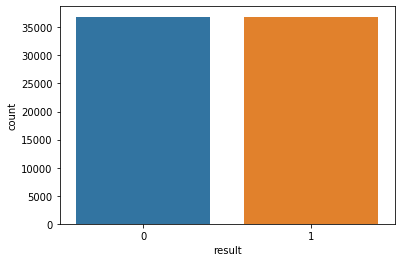

In [80]:
df2 = df.loc[:,df.columns[df.columns.isin(imp_feats)]]
X = df2.drop('result',1)
y = df2.result
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)


corr=df2.corr()
high_corr_var=np.where(corr>0.9)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
for tup in high_corr_var:
    print('Removing {} as it is highly correllated with {}'.format(tup[1],tup[0]))

to_drop = []
for x,y in high_corr_var:
  if y not in to_drop:
    to_drop.append(y)

df2 = df2.drop([i for i in to_drop],axis = 1)

corr=df2.corr()
high_corr_var=np.where(corr>0.9)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
assert high_corr_var == []
df2

In [ ]:
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
param_dict = {key:[] for key in ('best_score','best_params')}
for train_ix, test_ix in tqdm(cv_outer.split(X)):

    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier(random_state=1,n_jobs = -1)
    # define search space
    space = dict()
    space['n_estimators'] = [100, 500,1000]
    space['max_features'] = [3,6,12,24]
    # define search
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    param_dict['best_score'].append(result.best_score_)
    param_dict['best_params'].append(result.best_params_)
    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

In [ ]:
master_dict = {key:[] for key in ('max_features','trees','training_acc','testing_acc','testing_std')}
ests = [6,12,18,24,30,36,42]
trees = [100,250,500,1000,1500]
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y,random_state = 3)
for i in tqdm(ests):
    for j in trees:
        clf = RandomForestClassifier(n_estimators = j,max_features = i,n_jobs = -1,verbose = 1,class_weight = 'balanced')
        clf.fit(X_train,y_train)
        score1 = clf.score(X_train,y_train)
        master_dict['training_acc'].append(score1)
        score = cross_val_score(clf,X_train,y_train,cv = 5)
        #score = np.mean(score)
        master_dict['testing_acc'].append(np.mean(score))
        master_dict['testing_std'].append(np.std(score))  
        master_dict['max_features'].append(i)
        master_dict['trees'].append(j)

In [ ]:
pd.DataFrame.from_dict(master_dict)

In [ ]:
master_dict = {key:[] for key in ('trees','acc','std')}
for i in tqdm(range(50,1500,50)):
    clf = xgb.XGBClassifier(n_jobs = -1,n_estimators = i)
    score = cross_val_score(clf,X_train,y_train,cv = 5,n_jobs = -1)
    master_dict['acc'].append(np.mean(score))
    master_dict['std'].append(np.std(score))
    master_dict['trees'].append(i)

In [ ]:
pd.DataFrame.from_dict(master_dict)

In [ ]:
master_dict = {key:[] for key in ('md','acc','std')}
for i in tqdm(range(1,20)):
    clf = xgb.XGBClassifier(n_jobs = -1,max_depth = i)
    score = cross_val_score(clf,X_train,y_train,cv = 5,n_jobs = -1)
    master_dict['acc'].append(np.mean(score))
    master_dict['std'].append(np.std(score))
    master_dict['md'].append(i)
pd.DataFrame.from_dict(master_dict)

In [22]:
xgb.XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [ ]:
master_dict = {key:[] for key in ('lr','acc','std')}
for i in tqdm(np.linspace(0.5,2,10)):
    clf = xgb.XGBClassifier(n_jobs = -1,max_depth = i)
    score = cross_val_score(clf,X_train,y_train,cv = 5,n_jobs = -1)
    master_dict['acc'].append(np.mean(score))
    master_dict['std'].append(np.std(score))
    master_dict['lr'].append(i)
pd.DataFrame.from_dict(master_dict)

In [114]:
clf = xgb.XGBClassifier(n_jobs = -1,
                        max_depth = 2,
                       subsample = 1,
                       n_estimators = 1000,
                       learning_rate = 0.0025)
clf.fit(X_train,y_train)
score1 = accuracy_score(y_train,clf.predict(X_train))
score2 = accuracy_score(y_test,clf.predict(X_test))
print(score1,score2)

C:\Users\fmath\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:57:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7579281567489115 0.7538369435071296


In [116]:
clf = LogisticRegression(max_iter = 10000)
clf.fit(X_train,y_train)
score1 = accuracy_score(y_train,clf.predict(X_train))
score2 = accuracy_score(y_test,clf.predict(X_test))
print(score1,score2)

0.7734579100145138 0.7715794056819418


In [117]:
df_agg = pd.DataFrame()
for t in Teams(2022):
    try:
        temp_df = t.dataframe
        df_agg = pd.concat([df_agg,temp_df],axis=0)
    except:
        pass
        
in_agg = ['Southern Methodist','Brigham Young','University of California','Illinois-Chicago','Connecticut','Massachusetts','Nevada-Las Vegas','North Carolina',
         'North Carolina-Wilmington','North Carolina State','Pittsburgh','Louisiana State','Texas Christian','Southern California','Virginia Commonwealth']
to_change = ['SMU','BYU','California','UIC','UConn','UMass','UNLV','UNC','UNC Wilmington','NC State','Pitt','LSU','TCU','USC','VCU']
rename_dict = dict(zip(in_agg,to_change))
df_agg['name'] = df_agg.name.replace(rename_dict)
df_agg

,abbreviation,assist_percentage,assists,away_losses,away_wins,block_percentage,blocks,conference,conference_losses,conference_wins,defensive_rebounds,effective_field_goal_percentage,field_goal_attempts,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,free_throws,free_throws_per_field_goal_attempt,games_played,home_losses,home_wins,losses,minutes_played,name,net_rating,offensive_rating,offensive_rebound_percentage,offensive_rebounds,opp_assist_percentage,opp_assists,opp_block_percentage,opp_blocks,opp_defensive_rebounds,opp_effective_field_goal_percentage,opp_field_goal_attempts,opp_field_goal_percentage,opp_field_goals,opp_free_throw_attempt_rate,opp_free_throw_attempts,opp_free_throw_percentage,opp_free_throws,opp_free_throws_per_field_goal_attempt,opp_offensive_rating,opp_offensive_rebound_percentage,opp_offensive_rebounds,opp_personal_fouls,opp_points,opp_steal_percentage,opp_steals,opp_three_point_attempt_rate,opp_three_point_field_goal_attempts,opp_three_point_field_goal_percentage,opp_three_point_field_goals,opp_two_point_field_goal_attempts,opp_two_point_field_goal_percentage,opp_two_point_field_goals,opp_total_rebound_percentage,opp_total_rebounds,opp_true_shooting_percentage,opp_turnover_percentage,opp_turnovers,pace,personal_fouls,points,simple_rating_system,steal_percentage,steals,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_attempts,three_point_field_goal_percentage,three_point_field_goals,two_point_field_goal_attempts,two_point_field_goal_percentage,two_point_field_goals,total_rebound_percentage,total_rebounds,true_shooting_percentage,turnover_percentage,turnovers,win_percentage,wins
ABILENE-CHRISTIAN,ABILENE-CHRISTIAN,58.0,142,2,1,6.3,15,wac,0,0,194,0.517,534,0.459,245,0.324,173,0.694,120,0.225,8,0,5,2,335,Abilene Christian,None,108.7,30.5,95,53.1,86,7.3,26,216,0.457,406,0.399,162,0.468,190,0.726,138,0.340,None,25.7,67,168,509,8.1,50,0.411,167,0.281,47,239,0.481,115,49.5,283,0.513,27.0,184,73.8,181,672,9.18,15.0,93,0.38,0.335,179,0.346,62,355,0.515,183,50.5,289,0.545,14.2,102,0.750,6
AIR-FORCE,AIR-FORCE,55.2,116,1,1,12.0,37,mwc,0,0,214,0.563,437,0.481,210,0.259,113,0.664,75,0.172,9,0,4,2,360,Air Force,None,97.4,17.9,43,41.5,76,7.4,18,197,0.449,455,0.402,183,0.349,159,0.755,120,0.264,None,27.5,81,148,529,9.5,55,0.321,146,0.295,43,309,0.453,140,52.0,278,0.499,19.6,129,64.6,157,567,-5.96,11.2,65,-10.18,0.446,195,0.369,72,242,0.570,138,48.0,257,0.578,21.8,137,0.778,7
AKRON,AKRON,46.2,96,1,0,9.1,27,mac,0,0,218,0.526,455,0.457,208,0.387,176,0.636,112,0.246,8,0,4,3,320,Akron,None,109.4,34.7,95,35.6,62,6.7,18,179,0.444,445,0.391,174,0.281,125,0.672,84,0.189,None,24.6,71,162,479,8.3,45,0.335,149,0.315,47,296,0.429,127,44.4,250,0.475,17.5,107,67.6,141,591,-0.73,9.8,53,0.10,0.409,186,0.339,63,269,0.539,145,55.6,313,0.549,15.3,97,0.625,5
ALABAMA-AM,ALABAMA-AM,43.0,64,6,0,6.8,15,swac,0,0,167,0.377,434,0.343,149,0.219,95,0.695,66,0.152,7,0,1,6,280,Alabama A&M,None,79.9,26.0,78,67.2,117,9.0,29,222,0.504,417,0.417,174,0.297,124,0.758,94,0.225,None,35.0,90,106,514,10.0,49,0.475,198,0.364,72,219,0.466,102,56.0,312,0.540,17.5,101,70.2,120,393,-17.27,11.2,55,0.02,0.253,110,0.264,29,324,0.370,120,44.0,245,0.410,16.5,95,0.143,1
ALABAMA-BIRMINGHAM,ALABAMA-BIRMINGHAM,47.3,131,1,1,11.9,37,cusa,0,0,215,0.524,593,0.467,277,0.260,154,0.688,106,0.179,9,0,5,2,360,Alabama-Birmingham,None,112.0,33.3,115,52.0,105,7.7,30,230,0.492,480,0.421,202,0.319,153,0.706,108,0.225,None,28.8,87,143,580,7.1,46,0.352,169,0.402,68,311,0.431,134,49.0,317,0.525,24.8,182,72.2,156,728,16.05,17.5,114,2.18,0.339,201,0.338,68,392,0.533,209,51.0,330,0.546,13.2,101,0.778,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [95]:
imp_feats

['opp_win_percentage',
 'win_percentage',
 'home',
 'simple_rating_system',
 'opp_simple_rating_system',
 'offensive_rating',
 'opp_offensive_rating',
 'opp_true_shooting_percentage_allowed',
 'allowed_true_shooting_percentage',
 'opp_effective_field_goal_percentage_allowed',
 'allowed_effective_field_goal_percentage',
 'true_shooting_percentage',
 'allowed_field_goal_percentage',
 'opp_field_goal_percentage',
 'opp_field_goal_percentage_allowed',
 'field_goal_percentage',
 'opp_true_shooting_percentage',
 'effective_field_goal_percentage',
 'total_rebound_percentage',
 'opp_total_rebound_percentage_allowed',
 'opp_two_point_field_goal_percentage_allowed',
 'opp_effective_field_goal_percentage',
 'allowed_total_rebound_percentage',
 'allowed_two_point_field_goal_percentage',
 'opp_total_rebound_percentage',
 'opp_two_point_field_goal_percentage',
 'opp_turnover_percentage',
 'two_point_field_goal_percentage',
 'turnover_percentage',
 'opp_three_point_field_goal_percentage',
 'opp_three

In [147]:
team_1 = 'Purdue'
team_2 = 'NC State'
temp_df_2 = df_agg.loc[df_agg.name == team_1].loc[:,df_agg.columns[df_agg.columns.str.contains('percen') | df_agg.columns.str.contains('rat') | (df_agg.columns == 'pace') | (df_agg.columns == 'name')]]
temp_df_3 = df_agg.loc[df_agg.name == team_2].loc[:,df_agg.columns[df_agg.columns.str.contains('percen') | df_agg.columns.str.contains('rat') | (df_agg.columns == 'pace') | (df_agg.columns == 'name')]]
old_names = temp_df_2.columns[temp_df_2.columns.str.contains('opp_')].to_list()
new_names = [i.replace('opp','allowed') for i in temp_df_2.columns[temp_df_2.columns.str.contains('opp_')].to_list()]
name_dict = dict(zip(old_names,new_names))
temp_df_2_dict = temp_df_2.rename(columns = name_dict).to_dict(orient = 'list')
temp_df_2_dict.update(temp_df_3.iloc[0,:10].rename(dict(zip(temp_df_3.iloc[0,:10].index,['opp_'+str(i) for i in temp_df_3.iloc[0,:10].index]))).to_frame().transpose().to_dict(orient = 'list'))
temp_df_2_dict.update(temp_df_3.iloc[0,25:].rename(dict(zip(temp_df_3.iloc[0,25:].index,['opp_'+str(i) for i in temp_df_3.iloc[0,25:].index]))).to_frame().transpose().to_dict(orient = 'list'))
temp_df_2_dict.update(temp_df_3.iloc[0,10:25].rename(dict(zip(temp_df_3.iloc[0,10:25].index,[i + "_allowed" for i in temp_df_3.iloc[0,10:25].index]))).to_frame().transpose().to_dict(orient = 'list'))
temp_df_3_dict = temp_df_3.rename(columns = name_dict).to_dict(orient = 'list')
temp_df_3_dict.update(temp_df_2.iloc[0,:10].rename(dict(zip(temp_df_2.iloc[0,:10].index,['opp_'+str(i) for i in temp_df_2.iloc[0,:10].index]))).to_frame().transpose().to_dict(orient = 'list'))
temp_df_3_dict.update(temp_df_2.iloc[0,25:].rename(dict(zip(temp_df_2.iloc[0,25:].index,['opp_'+str(i) for i in temp_df_2.iloc[0,25:].index]))).to_frame().transpose().to_dict(orient = 'list'))
temp_df_3_dict.update(temp_df_2.iloc[0,10:25].rename(dict(zip(temp_df_2.iloc[0,10:25].index,[i + "_allowed" for i in temp_df_2.iloc[0,10:25].index]))).to_frame().transpose().to_dict(orient = 'list'))
for i in temp_df_3_dict.keys():
    temp_df_2_dict[i]+=(temp_df_3_dict[i])
master_dict = {key:[] for key in temp_df_2_dict.keys()}

for i in temp_df_2_dict.keys():
    master_dict[i] += temp_df_2_dict[i]
df_pred = pd.DataFrame.from_dict(master_dict)
for idx,i in enumerate(df_pred.columns):
    print(idx,i)


0 assist_percentage
1 block_percentage
2 effective_field_goal_percentage
3 field_goal_percentage
4 free_throw_attempt_rate
5 free_throw_percentage
6 name
7 net_rating
8 offensive_rating
9 offensive_rebound_percentage
10 allowed_assist_percentage
11 allowed_block_percentage
12 allowed_effective_field_goal_percentage
13 allowed_field_goal_percentage
14 allowed_free_throw_attempt_rate
15 allowed_free_throw_percentage
16 allowed_offensive_rating
17 allowed_offensive_rebound_percentage
18 allowed_steal_percentage
19 allowed_three_point_attempt_rate
20 allowed_three_point_field_goal_percentage
21 allowed_two_point_field_goal_percentage
22 allowed_total_rebound_percentage
23 allowed_true_shooting_percentage
24 allowed_turnover_percentage
25 pace
26 simple_rating_system
27 steal_percentage
28 three_point_attempt_rate
29 three_point_field_goal_percentage
30 two_point_field_goal_percentage
31 total_rebound_percentage
32 true_shooting_percentage
33 turnover_percentage
34 win_percentage
35 opp_ass

In [ ]:
df_pred[[i for i in df_pred.columns if i in x]]